# Data Clustering and Classification 

Load packages and configuration modules

In [101]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta, date
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import svm
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import time
import sys
import os

In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from helpers.db_connector import MySQLConnector
from helpers.data_process import *
from helpers.plotting import *
from helpers.db_query import *

## Data Preprocessing

In [4]:
%time video_events = getVideoEvents(mode='base')

Wall time: 10.8 s


In [5]:
%time video_events = delRepentants(video_events)

Wall time: 10.1 s


In [6]:
%time video_events = delLessActive(video_events)

Wall time: 1.26 s


In [7]:
video_events.head()

,AccountUserID,Count,DataPackageID,VideoID,TimeStamp,EventType,Year
0,10094,98,EPFL-AlgebreLineaire-2017_T3,bd22143ef4524edfb0dbab0fbb275ca7,1513259282,Video.Play,2017
1,10094,98,EPFL-AlgebreLineaire-2017_T3,6f7c4414324047a4b9d12a1d87d5875e,1510064721,Video.Load,2017
2,10094,98,EPFL-AlgebreLineaire-2017_T3,97b12bced6d649a2bca7465b246a1b0f,1513088547,Video.Pause,2017
3,10094,98,EPFL-AlgebreLineaire-2017_T3,73f3f756e43047c0b161c9ea29fb08a2,1508761566,Video.Seek,2017
4,10094,98,EPFL-AlgebreLineaire-2017_T3,227d5967cb02415ca694728f475146e0,1510148759,Video.Play,2017


In [8]:
%time problem_events = getProblemEvents()

Wall time: 4.01 s


In [9]:
problem_events.head()

,AccountUserID,DataPackageID,ProblemID,TimeStamp,EventType,ProblemType,Year
0,46461,EPFL-AlgebreLineaire-2018,44c46d58e2eb440b9308893be55aae3c,1543677480,Problem.Check,Quiz,2018
1,11951,EPFL-AlgebreLineaire-2018,9066a9a110cc41fda2ac2ef9fb4fcd57,1540735290,Problem.Graded,Quiz,2018
2,47544,EPFL-AlgebreLineaire-2018,156c7a9ac95047f59e1f524a2f3bd074,1539081929,Problem.Show,Quiz,2018
3,47226,EPFL-AlgebreLineaire-2018,60c00d7ca5dc4ad7a123a37b8cf7d694,1540208569,Problem.Graded,Quiz,2018
4,9710,EPFL-AlgebreLineaire-2017_T3,60c00d7ca5dc4ad7a123a37b8cf7d694,1508256577,Problem.Check,Quiz,2017


## Feature Extraction

| Measure | Meaning | Description | Source | 
| --- | --- | --- | --- |
| PDH | Peak on day hour | Identifies if a student's activities are centred around a particular hour of the day | [1] |
| PWD | Peak on week day | Identifies if a student's activities are centred around a particular day of the week | [1] |
| WS1 | Weekly Similarities in daily activity | Identifies if student works on same weekdays | [1] | 
| WS2 | Weekly Similarities in daily activity | Identifies if there is a similar distribution of workload among weekdays | [1] | 
| WS3 | Weekly Similarities in daily activity | Identifies if there is a similar time repartition of workload among weekdays | [1] | 
| FDH | Hourly Pattern over days | Identifies if hourly pattern is repeating over days | [1] | 
| FWH | Hourly Pattern over weeks | Identifies if hourly pattern is repeating over weeks| [1] | 
| FWD | Daily Pattern over Weeks | Identifies if daily pattern is repeating over weeks | [1] |
| NQZ | Number of quiz |Counts the total number of quiz completed by a student over the semester | - |
| PQZ | Percentage of quiz | Counts the percentage of quiz completed by a student over the flipped period| - |

### Video Events

In [1]:
video_events_feature_types = [PDH, PWD, WS1, WS2, WS3, FDH, FWH, FWD]

NameError: name 'PDH' is not defined

In [14]:
video_events_feature_vectors = {}
for studentID in tqdm(set(video_events['AccountUserID'])):
    sid, T, Lw = getStudentTimeStamps(video_events, studentID)
    video_events_feature_vectors[studentID] = []
    for ffunc in video_events_feature_types:
        video_events_feature_vectors[studentID].append(ffunc(Lw, T))

100%|██████████| 157/157 [05:38<00:00,  2.15s/it]


In [15]:
video_events_feature_vectors[studentID]

[9.441258895553373,
 6.700590744958262,
 0.2648148148148148,
 0.24207367134386126,
 0.24654527011421853,
 17.65414197625225,
 18.989650748013233,
 7.095618238594135]

### Problem Events

In [10]:
problem_events_feature_types = [NQZ, PQZ]

In [11]:
problem_events_feature_vectors = {}
for studentID in tqdm(set(video_events['AccountUserID'])):
    problem_events_feature_vectors[studentID] = []
    for ffunc in problem_events_feature_types:
        problem_events_feature_vectors[studentID].append(ffunc(problem_events, studentID))

100%|██████████| 157/157 [04:33<00:00,  1.74s/it]


In [12]:
problem_events_feature_vectors[studentID]

[1517, 4.397101449275362]

## Clustering

In [23]:
user_ids, user_vectors = list(video_events_feature_vectors.keys()), np.array(list(video_events_feature_vectors.values()))

In [24]:
user_vectors.shape

(157, 8)

Scale the feature vectors

In [31]:
scaled_user_vectors = StandardScaler().fit_transform(user_vectors)

Determine the number of clusters

In [35]:
kmeans_kwargs = {'init':'random', 'n_init':10, 'max_iter':300, 'random_state':42}

In [54]:
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_user_vectors)
    score = silhouette_score(scaled_user_vectors, kmeans.labels_)
    silhouette_coefficients.append(score)

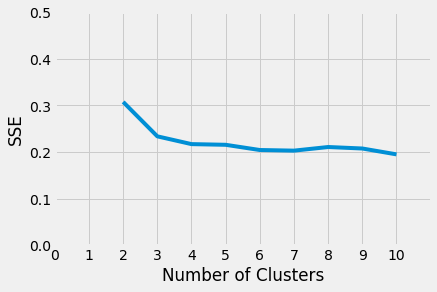

In [59]:
plotSilhouette(silhouette_coefficients)

Inspect the identified clusters

In [63]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs).fit(scaled_user_vectors)

In [64]:
kmeans.cluster_centers_

array([[ 0.61802292,  0.76199792,  0.71267289,  0.70982636,  0.69635694,
         0.4613704 ,  0.62474794,  0.76168496],
       [-0.51022822, -0.6290913 , -0.58836948, -0.58601944, -0.57489934,
        -0.38089882, -0.51578028, -0.62883294]])

In [67]:
pca = PCA(n_components=2).fit(scaled_user_vectors).transform(scaled_user_vectors)

In [68]:
pca.shape

(157, 2)

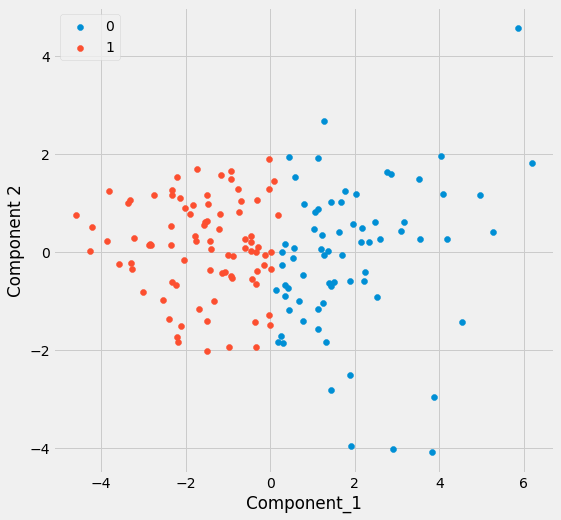

In [79]:
plt.figure(figsize=(8, 8))
for label in set(kmeans.labels_):
    indexes = np.array((kmeans.labels_==label).nonzero())
    plt.scatter(pca[indexes,0], pca[indexes,1], label=label)
plt.xlabel('Component_1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [89]:
pd.DataFrame(kmeans.cluster_centers_, columns=[str(f).split('at')[0][-4:-1] for f in video_events_feature_types])

,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
0,0.618023,0.761998,0.712673,0.709826,0.696357,0.461370,0.624748,0.761685
1,-0.510228,-0.629091,-0.588369,-0.586019,-0.574899,-0.380899,-0.515780,-0.628833


## Classification

In [92]:
X, y = scaled_user_vectors, kmeans.labels_

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [94]:
clf = svm.SVC(decision_function_shape='ovo').fit(X_train, y_train)

In [95]:
y_pred = clf.predict(X_test)

In [98]:
'Acc', accuracy_score(y_test, y_pred), 'Prec', accuracy_score(y_test, y_pred), 'Rec', accuracy_score(y_test, y_pred)

('Acc', 0.975, 'Prec', 0.975, 'Rec', 0.975)

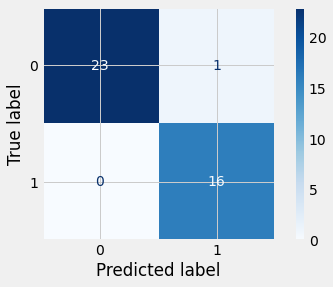

In [103]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=['0','1'], cmap=plt.cm.Blues)

## References

1. Boroujeni M.S., Sharma K., Kidziński Ł., Lucignano L., Dillenbourg P. (2016) How to Quantify Student’s Regularity?. In: Verbert K., Sharples M., Klobučar T. (eds) Adaptive and Adaptable Learning. EC-TEL 2016. Lecture Notes in Computer Science, vol 9891. Springer, Cham. https://doi.org/10.1007/978-3-319-45153-4_21

## Todo

- Create new features based on the available metadata
- Identify which features are the most discriminative
- Exploring the characteristics of the identified clusters
- Test classification using a temporal subset for the test set
- Link the score of success to possible hints to provide to students, i.e., which feature should I change to increase success 
- Think about possible applications, e.g., providing a score of success, providing hints to increase it
- Embed logic to determine what the student should do next to increase the probability of success, with explanations